In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os, sys
from tqdm import tqdm
from matplotlib import colors

from cell_inference.config import paths, params
from cell_inference.cells.simulation import SIMULATION_CLASS
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.random_parameter_generator import generate_predicted_parameters_from_config
from cell_inference.utils.transform.geometry_transformation import unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.data_transform import log_moulus_nfold
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp, scaled_stats_indices, GRID_SHAPE
from cell_inference.utils.data_manager import NpzFilesCollector
from cell_inference.utils.metrics.corrcoef import cossim, corrcoef
import cell_inference.utils.feature_extractors.SummaryStats2D as ss2
import data_simulation_prediction

%matplotlib inline

overwrite_saved_results = False
simulate_prediction = False
save_stats = True

## Load data

#### In vivo data

In [2]:
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample_v2'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = os.path.join(paths.INVIVO_DATA_PATH, invivo_name)
INVIVO_DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
INVIVO_STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics
INVIVO_FEATURE_PATH = os.path.join(INVIVO_PATH, 'features_' + invivo_name + '.csv')  # in vivo data features

with h5py.File(INVIVO_DATA_PATH,'r') as hf, np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
    IDs = hf['ID'][()][INVIVO_LFP['good_indices']]

with np.load(INVIVO_STATS_PATH) as INVIVO_STATS:
    invivo_stats = INVIVO_STATS['x']
    layer = INVIVO_STATS['layer'] # use cortical layers as labels
#     layer = INVIVO_STATS['class_'] # use cell classes as labels
    y_c = INVIVO_STATS['yc']

layer_idx = {L: layer==L for L in np.unique(layer)}
sort_idx = np.argsort(list(layer_idx.keys()))
# sort_idx = np.argsort(np.array([np.count_nonzero(idx) for idx in layer_idx.values()]))
layer_idx = dict(zip(np.asarray(list(layer_idx))[sort_idx], np.asarray(list(layer_idx.values()))[sort_idx]))
layer_names = list(layer_idx)
nlayers = len(layer_names)
layer_clr = np.array([['lightcyan', 'mistyrose', 'lemonchiffon'], ['darkcyan', 'darkred', 'goldenrod']]).T[:nlayers]

#### Simulation data

In [3]:
TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats' # select trial

DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    sim_stats = STATS['x']
n_sim_stats = sim_stats.shape[1]

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range'].copy()
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
#     orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
#     orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'
    ranges['ys'] = [-150, 150] # set bound for normalization

#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

### Get magnitude distribution

In [7]:
scaled_idx = scaled_stats_indices()
max_mag_idx = [33, 38]
max_mag = np.amax(sim_stats[:, max_mag_idx], axis=1)
max_mag_invivo = np.amax(invivo_stats[:, max_mag_idx], axis=1)
mag_scale = np.mean(max_mag) / np.mean(max_mag_invivo)
invivo_stats_scaled = invivo_stats.copy()
invivo_stats_scaled[:, scaled_idx] *= mag_scale
invivo_stats_scaled = invivo_stats_scaled[:, :sim_stats.shape[1]]
print(mag_scale)

0.037508497617022935


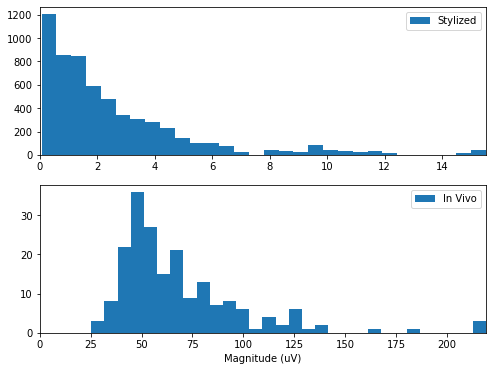

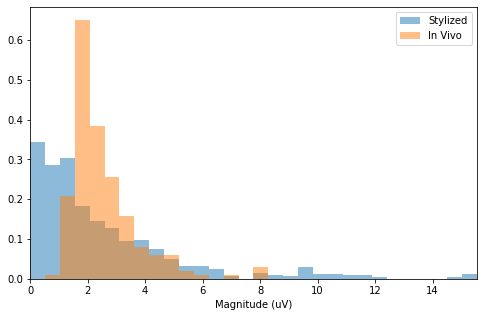

In [8]:
nbins = 30

plt.figure(figsize=(8, 6))
plt.subplot(211)
_, bins, _ = plt.hist(max_mag, bins=nbins, label='Stylized')
plt.xlim([0,bins[-1]])
plt.legend()
plt.subplot(212)
_, bins, _ = plt.hist(max_mag_invivo, bins=nbins, label='In Vivo')
plt.xlim([0,bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')

bins = np.linspace(0, max(np.amax(max_mag), np.amax(mag_scale * max_mag_invivo)), nbins + 1)
plt.figure(figsize=(8, 5))
plt.hist(max_mag, bins=bins, label='Stylized', density=True, alpha=0.5)
plt.hist(mag_scale * max_mag_invivo, bins=bins, label='In Vivo', density=True, alpha=0.5)
plt.xlim([0, bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')
plt.show()

## Load model

In [9]:
import torch

model_name = 'CNN_batch256' # select model
model_name = 'FCN_batch256'
isCNN = 'CNN' in model_name

if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)
PARAM_PATH = os.path.join(MODEL_PATH, model_name + '.pth')

PRED_PATH = os.path.join(MODEL_PATH, model_name + '_prediction.csv')
if not os.path.isfile(PRED_PATH):
    INVIVO_PRED_PATH = os.path.join(MODEL_PATH, invivo_name)
    PRED_PATH = os.path.join(INVIVO_PRED_PATH, model_name + '_prediction.csv')
    if not os.path.exists(INVIVO_PRED_PATH):
        os.makedirs(INVIVO_PRED_PATH)
        print("The new data directory is created!")
else:
    INVIVO_PRED_PATH = MODEL_PATH
CORR_PATH = os.path.join(INVIVO_PRED_PATH, model_name + '_correlation.csv')
overwrite_saved_results = overwrite_saved_results or not os.path.isfile(PRED_PATH)

if isCNN:
    from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork, ActivationTypes
    num_filters = [8, 16, 16, 32, 32, 64, 64, 64, 32, 8]
    model = ConvolutionalNetwork(in_channels=2, out_features=len(label_list), num_filters=num_filters)
else:
    from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
    model = FullyConnectedNetwork(in_features=n_sim_stats, out_features=len(label_list))

device = torch.device('cpu')
model.load_state_dict(torch.load(PARAM_PATH, map_location=device))
model.to(device)
model.eval()

FullyConnectedNetwork(
  (hidden_layers): Sequential(
    (0): Linear(in_features=72, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=124, bias=True)
    (3): ReLU()
    (4): Linear(in_features=124, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
  )
  (output_layers): Linear(in_features=16, out_features=7, bias=True)
)

#### Data for CNN

In [10]:
n_fold = 30
max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
n_fold = 2**max_logmod - 1

if overwrite_saved_results:
    if isCNN:
        with np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
            invivo_lfp_scaled = 1000 * mag_scale * INVIVO_LFP['x']  # mV -> uV, then scale invivo lfp
        lfp_trans = np.empty_like(invivo_lfp_scaled)
        for i in range(invivo_lfp_scaled.shape[0]):
            lfp_trans[i] = log_moulus_nfold(invivo_lfp_scaled[i], n_fold)

        lfp_trans = np.stack((invivo_lfp_scaled, lfp_trans), axis=1)
        lfp_trans = lfp_trans.reshape(lfp_trans.shape[:3] + (GRID_SHAPE[0], -1))

### Visualize network

In [11]:
# if isCNN:
#     with np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
#         invivo_lfp_scaled = 1000 * mag_scale * INVIVO_LFP['x']  # mV -> uV, then scale invivo lfp
#     lfp_trans = np.empty_like(invivo_lfp_scaled)
#     for i in range(invivo_lfp_scaled.shape[0]):
#         lfp_trans[i] = log_moulus_nfold(invivo_lfp_scaled[i], n_fold)

#     lfp_trans = np.stack((invivo_lfp_scaled, lfp_trans), axis=1)
#     lfp_trans = lfp_trans.reshape(lfp_trans.shape[:3] + (GRID_SHAPE[0], -1))

# input_ = torch.Tensor(lfp_trans).to(device)
# pred = model(input_)

# with open(os.path.join(MODEL_PATH, 'Network_architecture.txt'), 'w') as f:
#     print(model.train(True), file=f)

# # Torchviz
# from torchviz import make_dot
# dot = make_dot(pred, params=dict(model.named_parameters()))
# dot.render(filename=os.path.join(MODEL_PATH, model_name + '_architecture'))

# # # Tensorboard
# # from torch.utils.tensorboard import SummaryWriter
# # writer = SummaryWriter()
# # writer.add_graph(model, input_)

# # # Hiddenlayer
# # import hiddenlayer as hl
# # hl.build_graph(model, input_)

### Predict on in vivo data

In [12]:
if overwrite_saved_results:
    if isCNN:
        pred = model(torch.Tensor(lfp_trans).to(device)).to("cpu").detach().numpy()
    else:
        pred = model(torch.Tensor(invivo_stats_scaled).to(device)).to("cpu").detach().numpy()

    for i, lb in enumerate(label_list):
        pred[:, i] = org_scale(pred[:, i], ranges[lb])
    pred_list = label_list.copy()
    pred_list = label_list.copy()
    if has_yshift:
        pred[:, ys_idx] = y_c - pred[:, ys_idx]
        pred_list[pred_list.index('ys')] = 'y'
    if direction_vec:
        pred[:, orient_idx1] = trivarnorm2unitsphere(pred[:, orient_idx1])
        pred = np.hstack([pred, unitsphere2hphi(pred[:, orient_idx1])[:, [1]]])
        pred_list[pred_list.index('vy')] = 'h'
        pred_list.append('phi')
    pred_dict = dict(zip(pred_list, pred.T))
    pred_dict['layer'] = layer

    df_pred = pd.DataFrame(pred_dict, index=IDs)
    df_pred.to_csv(PRED_PATH, index_label='cell id') # save to csv
else:
    df_pred = pd.read_csv(PRED_PATH, index_col=0)
    pred_idx = df_pred.index.get_indexer(IDs)
    df_pred = df_pred.iloc[pred_idx]
    pred_dict = {key: np.array(value) for key, value in df_pred.to_dict(orient='list').items()}
    pred_list = list(pred_dict.keys())
    pred_list.remove('layer')
    pred = df_pred.drop('layer', axis=1).to_numpy()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_pred.sort_values(by='y'))

,y,d,theta,l_t,lr_pt,r_t,rr_dt,layer
cell id,,,,,,,,
395,-969.479500,150.095250,0.008017,1159.55920,-0.094220,0.560292,0.496212,Layer6
457,-965.542050,85.674770,0.098161,804.18640,0.260270,0.449134,0.713381,Layer6
68,-964.655900,80.693560,0.028907,1155.98020,0.319947,0.380808,0.706765,Layer6
494,-959.912230,66.073940,0.045289,926.19600,0.052106,0.727276,0.629428,Layer6
398,-930.396100,121.436430,0.157119,550.89984,0.168866,0.510675,0.647595,Layer6
497,-930.237300,122.875810,-0.066129,548.45950,0.208233,0.479894,0.581688,Layer6
85,-925.583800,144.387180,0.023417,468.18506,0.212805,0.494731,0.635438,Layer6
78,-922.826200,160.488680,-0.430648,624.46450,0.236586,0.540717,0.585861,Layer6
396,-910.587600,95.644910,-0.454963,670.83280,0.414195,0.383518,0.612440,Layer6


In [13]:
corr_cut = 0.25  # cutoff correlation value for good prediction
corr_type = 'Coss'  # 'Log_Coss'
if os.path.isfile(CORR_PATH):
    df_corr = pd.read_csv(CORR_PATH, index_col='cell id').loc[IDs]
    corr = df_corr[corr_type].values
    hi_corr = corr > corr_cut
else:
    hi_corr = np.full(IDs.size, True)

layer_indices = np.array([[hi_corr & idx if j else ~hi_corr & idx for j in range(2)] for idx in layer_idx.values()])
layer_label = np.core.defchararray.add(np.array(layer_names).reshape(-1, 1), np.array([' low', ' high']))

In [14]:
if check_orient:
    bins = 30
    avg_direct = trivarnorm2unitsphere(np.mean(pred[:, orient_idx1], axis=0))
    deviation_ang = np.arccos(pred[:, orient_idx1] @ avg_direct.T)
    weights = 1 / np.sin(np.fmax(deviation_ang, np.pi / bins / 8))
    deviation_ang *= 180 / np.pi
    print('Average direction vector (vx, vy, vz) = (%.3f, %.3f, %.3f)' % tuple(avg_direct))
    print('%.2f degrees away from vertical' % (180 / np.pi * np.arccos(avg_direct[1])))
    print('Average deviation angle %.2f degrees' % (np.mean(deviation_ang)))
    avg_direct_grp = np.empty((nlayers, 2, 3))

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 5, (1, 2))
    plt.gca().add_artist(plt.Circle((0., 0.), 1.0, edgecolor='k', fill=False))
    plt.plot(0., 0., 'ko', label='y direction')
    plt.plot(*avg_direct[[2, 0]], 'go', markersize=8, markerfacecolor='None', markeredgewidth=2, label='average direction')
    for j in range(2):
        for i in range(nlayers):
            idx = layer_indices[i, j]
            if np.count_nonzero(idx) == 0:
                avg_direct_grp[i, j, :] = np.nan
                continue
            avg_direct_grp[i, j, :] = trivarnorm2unitsphere(np.mean(pred[idx][:, orient_idx1], axis=0))
            plt.plot(avg_direct_grp[i, j, 2], avg_direct_grp[i, j, 0], linestyle='None', marker='o', 
                     markersize=8, markerfacecolor='None', markeredgewidth=2, color=layer_clr[i, j])
            plt.plot(pred_dict['vz'][idx], pred_dict['vx'][idx], marker='.',
                     linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
    plt.xlabel('vz')
    plt.ylabel('vx')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.legend(framealpha=0.1)
    plt.title('Direction unit vectors')

    plt.subplot(1, 5, (3, 5))
    plt.hist([deviation_ang[idx] for idx in layer_indices.reshape(nlayers * 2, -1)],
             weights=[weights[idx] for idx in layer_indices.reshape(nlayers * 2, -1)],
             bins=bins, range=(0, 90), density=True, stacked=True, color=layer_clr.ravel(), label=layer_label.ravel())
    plt.xlim([0, 90])
    plt.xlabel('Deviation angle from average direction (deg)')
    plt.ylabel('density')
    plt.legend(framealpha=0.1)

    print('Cutoff value of groups with (low, high) similarity: %.3f' % corr_cut)
    print('Deviation angle (deg) from vertical of average orientation of each group: ')
    for i in range(nlayers):
        print(layer_names[i] + ': (%.2f, %.2f)' % tuple(180 / np.pi * np.arccos(avg_direct_grp[i, :, 1])))

    plt.tight_layout()
    plt.show()

In [15]:
from cell_inference.utils.plotting.plot_all_cells import plot_all_cells
%matplotlib inline
# %matplotlib notebook

if check_orient:
    elev = 180 / np.pi * np.arcsin(avg_direct[1])
    azim = 180 / np.pi * np.arctan2(*avg_direct[[0, 2]])

    ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
    ax.plot3D(0, 0, 0, 'ko', label='origin')
    ax.plot3D(*avg_direct[[2, 0, 1]], 'go', markersize=8, markerfacecolor='None', markeredgewidth=2, label='average direction')
    for j in range(2):
        for i in range(nlayers):
            idx = layer_indices[i, j]
            if np.count_nonzero(idx) == 0:
                continue
            ax.plot3D(avg_direct_grp[i, j, 2], avg_direct_grp[i, j, 0], avg_direct_grp[i, j, 1], linestyle='None', 
                      marker='o', markersize=8, markerfacecolor='None', markeredgewidth=2, color=layer_clr[i, j])
            ax.plot3D(pred_dict['vz'][idx], pred_dict['vx'][idx], pred_dict['h'][idx],
                      marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
    ax.set_xlabel('vz')
    ax.set_ylabel('vx')
    ax.set_zlabel('vy')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.view_init(elev=elev, azim=azim)
    ax.legend(framealpha=0.1)
    ax.set_title('Direction unit vectors (viewed from average direction)')

    fig, ax = plot_all_cells(df_pred.loc[hi_corr], figsize=(10, 8), view='2D')
    ax.set_title('3D plot of all cells (side view)')
    fig, ax = plot_all_cells(df_pred.loc[hi_corr], figsize=(10, 8), view=(90, -90))
    ax.set_title('3D plot of all cells (top view)')

    plt.show()

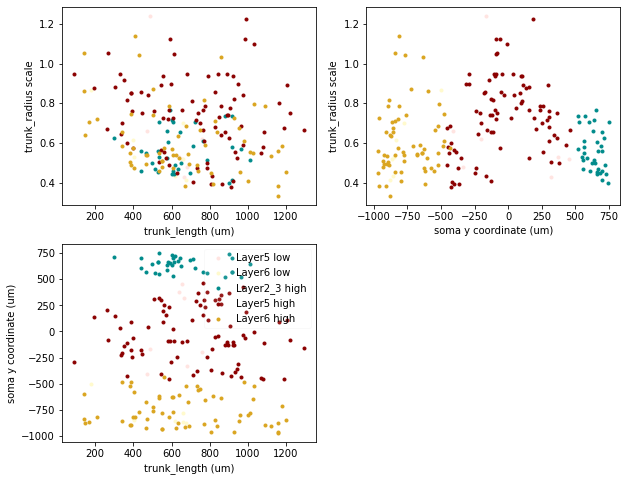

In [16]:
plt.figure(figsize=(10, 8))
for j in range(2):
    for i in range(nlayers):
        idx = layer_indices[i, j]
        if np.count_nonzero(idx) == 0:
            continue
        plt.subplot(221)
        plt.plot(pred_dict['l_t'][idx], pred_dict['r_t'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
        plt.subplot(222)
        plt.plot(pred_dict['y'][idx], pred_dict['r_t'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
        plt.subplot(223)
        plt.plot(pred_dict['l_t'][idx], pred_dict['y'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
plt.subplot(221)
plt.xlabel('trunk_length (um)')
plt.ylabel('trunk_radius scale')
plt.subplot(222)
plt.xlabel('soma y coordinate (um)')
plt.ylabel('trunk_radius scale')
plt.subplot(223)
plt.xlabel('trunk_length (um)')
plt.ylabel('soma y coordinate (um)')
plt.legend(framealpha=0.1)
plt.show()

In [17]:
# layer_label = np.core.defchararray.add(np.array(layer_names).reshape(-1, 1), np.array([' low', '']))
# plt.figure(figsize=(5, 5))
# for j in range(2):
#     for i in range(nlayers):
#         idx = layer_indices[i, j]
#         if np.count_nonzero(idx) == 0:
#             continue
#         plt.plot(pred_dict['l_t'][idx], pred_dict['y'][idx],
#                  marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
# plt.xlabel('trunk_length (μm)')
# plt.ylabel('soma y coordinate (μm)')
# plt.legend(framealpha=0.1)
# plt.show()

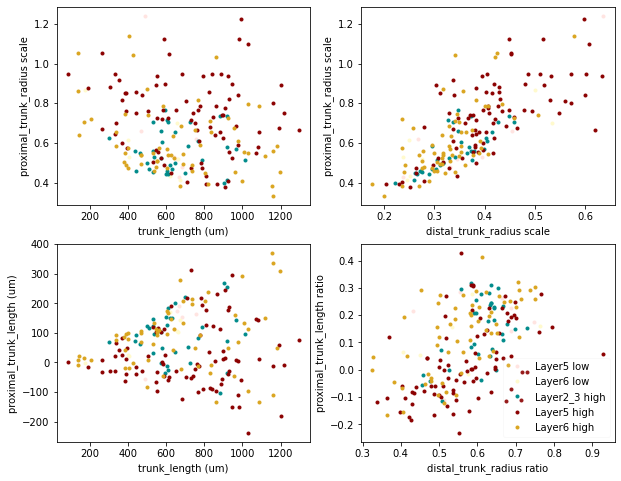

In [18]:
if 'lr_pt' in label_list and 'rr_dt' in label_list:
    plt.figure(figsize=(10, 8))
    for j in range(2):
        for i in range(nlayers):
            idx = layer_indices[i, j]
            if np.count_nonzero(idx) == 0:
                continue
            plt.subplot(221)
            plt.plot(pred_dict['l_t'][idx], pred_dict['r_t'][idx],
                     marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
            plt.subplot(222)
            plt.plot(pred_dict['rr_dt'][idx] * pred_dict['r_t'][idx], pred_dict['r_t'][idx],
                     marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
            plt.subplot(223)
            plt.plot(pred_dict['l_t'][idx], pred_dict['lr_pt'][idx] * pred_dict['l_t'][idx],
                     marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
            plt.subplot(224)
            plt.plot(pred_dict['rr_dt'][idx], pred_dict['lr_pt'][idx],
                     marker='.', linestyle='None', color=layer_clr[i, j], label=layer_label[i, j])
    plt.subplot(221)
    plt.xlabel('trunk_length (um)')
    plt.ylabel('proximal_trunk_radius scale')
    plt.subplot(222)
    plt.xlabel('distal_trunk_radius scale')
    plt.ylabel('proximal_trunk_radius scale')
    plt.subplot(223)
    plt.xlabel('trunk_length (um)')
    plt.ylabel('proximal_trunk_length (um)')
    plt.subplot(224)
    plt.xlabel('distal_trunk_radius ratio')
    plt.ylabel('proximal_trunk_length ratio')
    plt.legend(framealpha=0.1)
    plt.show()

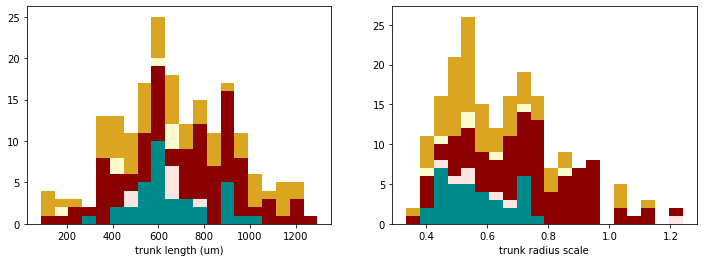

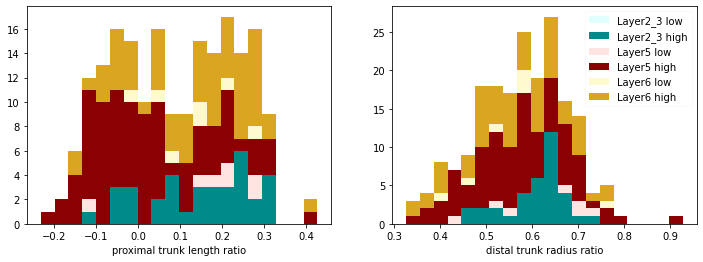

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([pred_dict['l_t'][idx] for idx in layer_indices.reshape(nlayers * 2, -1)],
         bins=20, stacked=True, color=layer_clr.ravel(), label=layer_label.ravel())
plt.xlabel('trunk length (um)')
plt.subplot(122)
plt.hist([pred_dict['r_t'][idx] for idx in layer_indices.reshape(nlayers * 2, -1)],
         bins=20, stacked=True, color=layer_clr.ravel(), label=layer_label.ravel())
plt.xlabel('trunk radius scale')

if 'lr_pt' in label_list and 'rr_dt' in label_list:
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.hist([pred_dict['lr_pt'][idx] for idx in layer_indices.reshape(nlayers * 2, -1)],
         bins=20, stacked=True, color=layer_clr.ravel(), label=layer_label.ravel())
    plt.xlabel('proximal trunk length ratio')
    plt.subplot(122)
    plt.hist([pred_dict['rr_dt'][idx] for idx in layer_indices.reshape(nlayers * 2, -1)],
         bins=20, stacked=True, color=layer_clr.ravel(), label=layer_label.ravel())
    plt.xlabel('distal trunk radius ratio')

plt.legend(framealpha=0.1)
plt.show()

## Simulate with predicted parameters

In [20]:
if INVIVO_PRED_PATH == MODEL_PATH:
    data_simulation_prediction.INVIVO_PRED_PATH = INVIVO_PRED_PATH
    data_simulation_prediction.set_path(trial=TRIAL_NAME, model=model_name)
else:
    data_simulation_prediction.set_path(trial=TRIAL_NAME, model=model_name, invivo=invivo_name)
PRED_LFP_PATH = data_simulation_prediction.PRED_LFP_PATH
PRED_STATS_PATH = data_simulation_prediction.PRED_STATS_PATH
if not os.path.isfile(PRED_LFP_PATH) or not os.path.isfile(PRED_STATS_PATH):
    if simulate_prediction:
        data_simulation_prediction.run_pred_simulation(config_dict, pred_dict, save_stats=save_stats)
    else:
        try:
            PRED_DATA = []
            if not os.path.isfile(PRED_LFP_PATH):
                PRED_DATA.append(NpzFilesCollector(PRED_LFP_PATH))
            if save_stats and not os.path.isfile(PRED_STATS_PATH):
                PRED_DATA.append(NpzFilesCollector(PRED_STATS_PATH))
        except:
            raise ValueError("Simulation data not generated for predictions.")
        else:
            for f in PRED_DATA:
                with f:
                    f.save_to_single_file() # convert data in multiple files to a single file
                    f.delete_files() # delete multiple files

## Evaluate prediction

In [21]:
with np.load(PRED_LFP_PATH, allow_pickle=True) as PRED_LFP:
    good_indices = PRED_LFP['valid'][PRED_LFP['good_indices']]
    pred_lfp = PRED_LFP['x'][np.isin(good_indices, pred_idx)]
    bad_indices = PRED_LFP['bad_indices'].item()

good_indices = np.isin(pred_idx, good_indices)
with np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
    invivo_lfp = INVIVO_LFP['x'][good_indices]
    t = INVIVO_LFP['t']

invalid = np.full(IDs.size, True)
invalid[good_indices] = False
invalid = np.nonzero(invalid)[0]
ids = IDs[good_indices]

print('%d invalid IDs: ' % (len(invalid)))
print(IDs[invalid])
for bad, indices in bad_indices.items():
        print('Bad case %d bad: %d samples.' % (bad, np.count_nonzero(np.isin(indices, pred_idx))))

0 invalid IDs: 
[]
Bad case -1 bad: 42 samples.
Bad case 0 bad: 154 samples.
Bad case 1 bad: 0 samples.
Bad case 2 bad: 0 samples.
Bad case 3 bad: 0 samples.


#### Calculate cosine similarity and correlation coefficient

In [22]:
corr = np.empty(pred_lfp.shape[0])  # linear scale
corr_log = np.empty(pred_lfp.shape[0])  # log modulus transformed
coss = np.empty(pred_lfp.shape[0])  # linear scale
coss_log = np.empty(pred_lfp.shape[0])  # log modulus transformed
for i in range(pred_lfp.shape[0]):
    log_invivo = log_moulus_nfold(invivo_lfp[i], n_fold)
    log_pred = log_moulus_nfold(pred_lfp[i], n_fold)
    corr[i] = corrcoef(invivo_lfp[i], pred_lfp[i])
    corr_log[i] = corrcoef(log_invivo, log_pred)
    coss[i] = cossim(invivo_lfp[i], pred_lfp[i])
    coss_log[i] = cossim(log_invivo, log_pred)

df_corr = pd.DataFrame({'Corr': corr, 'Log_Corr': corr_log, 'Coss': coss, 'Log_Coss': coss_log, 
                        'layer': layer[good_indices]}, index=ids).sort_values('Corr')
df_corr = pd.concat((pd.DataFrame({'Corr': np.nan, 'Log_Corr': np.nan, 'Coss': np.nan, 'Log_Coss': np.nan, 
                                   'layer': layer[invalid]}, index=IDs[invalid]), df_corr))
if overwrite_saved_results or not os.path.isfile(CORR_PATH):
    df_corr.to_csv(CORR_PATH, index_label='cell id')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_corr)

,Corr,Log_Corr,Coss,Log_Coss,layer
501,-0.627554,-0.517148,-0.627554,-0.517148,Layer6
89,-0.357256,-0.167350,-0.357256,-0.167350,Layer6
503,-0.125920,-0.067889,-0.125920,-0.067889,Layer6
138,-0.038770,-0.093314,-0.038770,-0.093314,Layer5
404,-0.028923,0.064063,-0.028923,0.064063,Layer6
270,0.046973,-0.166760,0.046973,-0.166760,Layer5
277,0.092088,0.035986,0.092088,0.035986,Layer5
88,0.133623,0.125754,0.133623,0.125754,Layer6
506,0.136342,-0.022700,0.136342,-0.022700,Layer6
288,0.141386,0.119697,0.141386,0.119697,Layer5


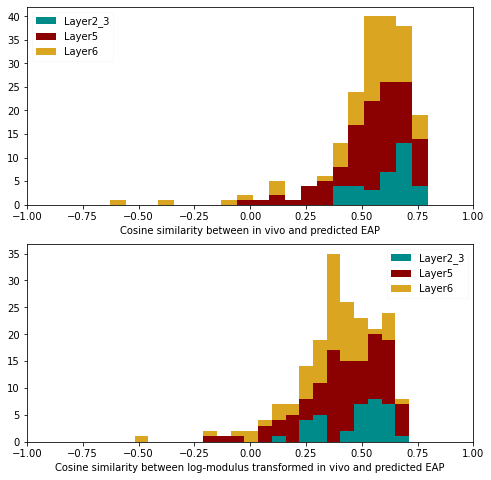

In [23]:
# plt.figure(figsize=(8, 8))
# plt.subplot(211)
# plt.hist([corr[idx[good_indices]] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr[:, 1], stacked=True)
# plt.xlabel('Correlation coefficient between in vivo and predicted LFP')
# plt.xlim([-1, 1])
# plt.legend(framealpha=0.1)
# plt.subplot(212)
# plt.hist([corr_log[idx[good_indices]] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr[:, 1], stacked=True)
# plt.xlabel('Correlation coefficient between log-modulus transformed in vivo and predicted LFP')
# plt.xlim([-1, 1])
# plt.legend(framealpha=0.1)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.hist([coss[idx[good_indices]] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr[:, 1], stacked=True)
plt.xlabel('Cosine similarity between in vivo and predicted EAP')
plt.xlim([-1, 1])
plt.legend(framealpha=0.1)
plt.subplot(212)
plt.hist([coss_log[idx[good_indices]] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr[:, 1], stacked=True)
plt.xlabel('Cosine similarity between log-modulus transformed in vivo and predicted EAP')
plt.xlim([-1, 1])
plt.legend(framealpha=0.1)

plt.show()

### Features vs. cosine similarity

In [24]:
pd_features = pd.read_csv(INVIVO_FEATURE_PATH, index_col='cell id')

fit_pts_name = ['troughs_left', 'troughs_right', 'peaks_left', 'peaks_right']
pts_name = ['w1', 'w2', 'y1']
fit_pts = pd_features[[name+'_'+pt for name in fit_pts_name for pt in pts_name]].to_numpy().reshape(-1, 4, 3)
spike_width = pd_features['spike_width'].values

Color limit: (-0.63, 0.80)


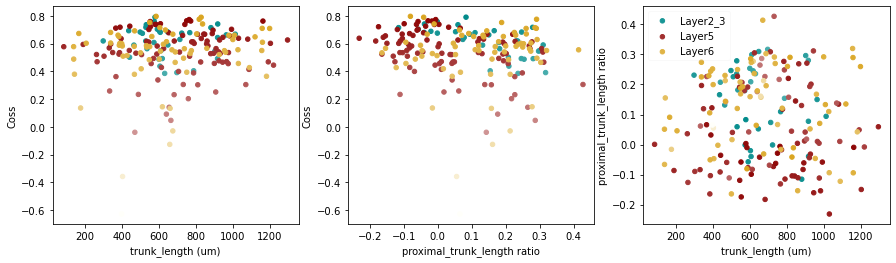

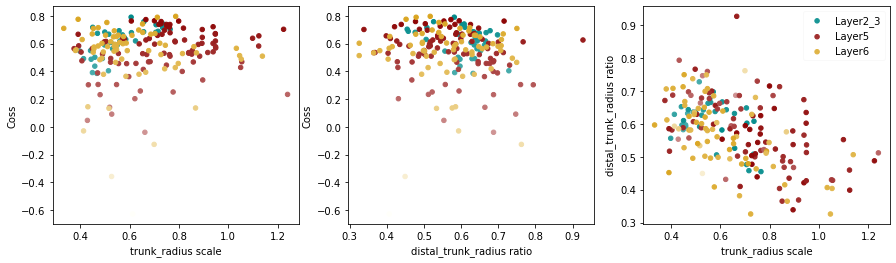

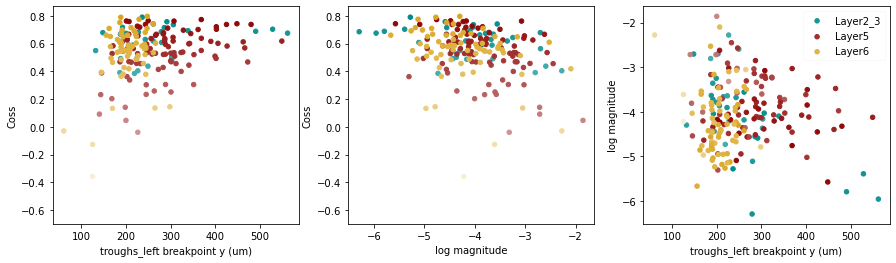

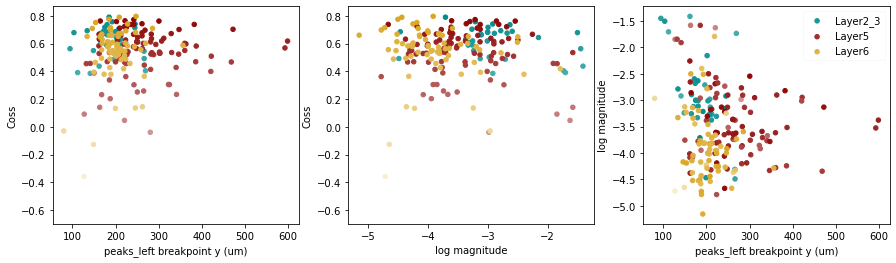

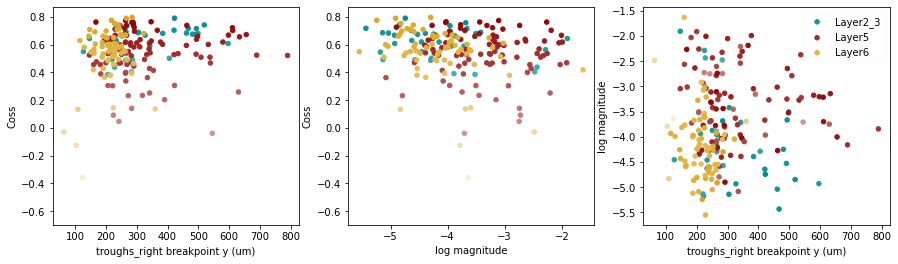

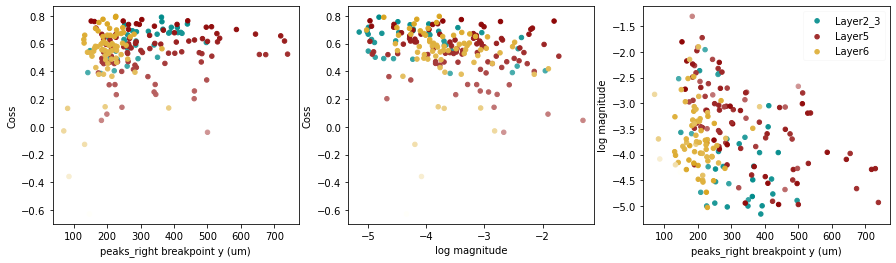

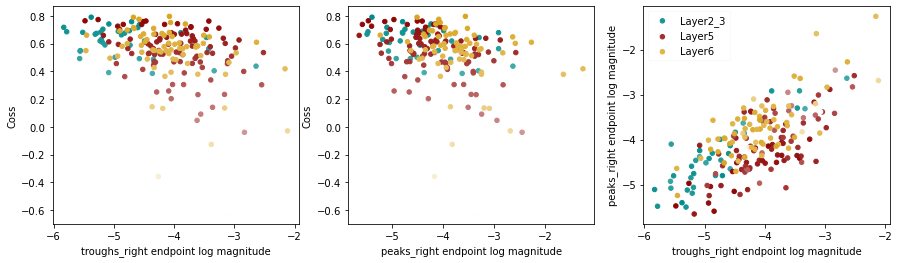

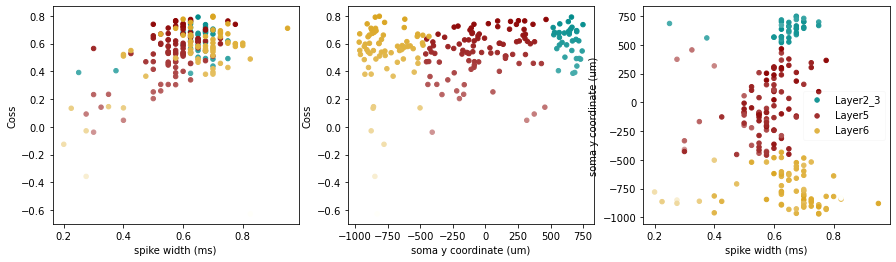

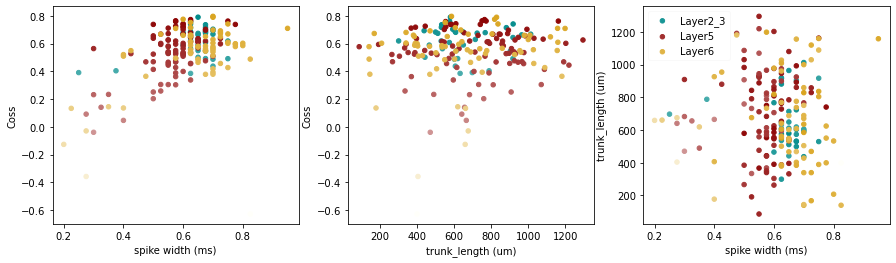

In [25]:
ft = [
    (('vz', 'vx'), (pred_dict['vz'], pred_dict['vx'])),
    (('vy / h', ), (pred_dict['h'], ))
] if check_orient else []
    
ft += [
    (('trunk_length (um)', 'proximal_trunk_length ratio'), (pred_dict['l_t'], pred_dict['lr_pt'])),
    (('trunk_radius scale', 'distal_trunk_radius ratio'), (pred_dict['r_t'], pred_dict['rr_dt'])),
    ((fit_pts_name[0]+' breakpoint y (um)', 'log magnitude'), (fit_pts[:, 0, 2], fit_pts[:, 0, 0])),
    ((fit_pts_name[2]+' breakpoint y (um)', 'log magnitude'), (fit_pts[:, 2, 2], fit_pts[:, 2, 0])),
    ((fit_pts_name[1]+' breakpoint y (um)', 'log magnitude'), (fit_pts[:, 1, 2], fit_pts[:, 1, 0])),
    ((fit_pts_name[3]+' breakpoint y (um)', 'log magnitude'), (fit_pts[:, 3, 2], fit_pts[:, 3, 0])),
    ((fit_pts_name[1]+' endpoint log magnitude', fit_pts_name[3]+' endpoint log magnitude'), (fit_pts[:, 1, 1], fit_pts[:, 3, 1])),
    (('spike width (ms)', 'soma y coordinate (um)'), (spike_width, pred_dict['y'])),
    (('spike width (ms)', 'trunk_length (um)'), (spike_width, pred_dict['l_t']))
]

corr_type = 'Coss'  # 'Log_Coss'
co = df_corr[corr_type].loc[IDs].values
vmin, vmax = np.nanmin(co), np.nanmax(co)
co = np.nan_to_num(co, nan=vmin)
print('Color limit: (%.2f, %.2f)' % (vmin, vmax))

clr_scl = 0.1
scl_clr = [[1-clr_scl + clr_scl*np.array(colors.to_rgb(c[0])), colors.to_rgb(c[1])] for c in layer_clr]
cmap = [colors.LinearSegmentedColormap.from_list(layer_names[i], scl_clr[i]) for i in range(nlayers)]
for name, data in ft:
    name += (corr_type, )
    data += (co, )
    if len(data) > 2:
        _, ax = plt.subplots(1, 3, figsize=(15, 4), squeeze=False)
        dpair = [[0, 2], [1, 2], [0, 1]]
    else:
        _, ax = plt.subplots(1, 1, figsize=(5, 4), squeeze=False)
        dpair = [[0, 1]]
    ax = ax[0]
    for j, (d1, d2) in enumerate(dpair):
        for i, (L, idx) in enumerate(layer_idx.items()):
            ax[j].scatter(data[d1][idx], data[d2][idx], c=co[idx], s=20, cmap=cmap[i], vmin=vmin, vmax=vmax, label=L)
        ax[j].set_xlabel(name[d1])
        ax[j].set_ylabel(name[d2])
    ax[-1].legend(framealpha=0.1)
plt.show()

Simulated data


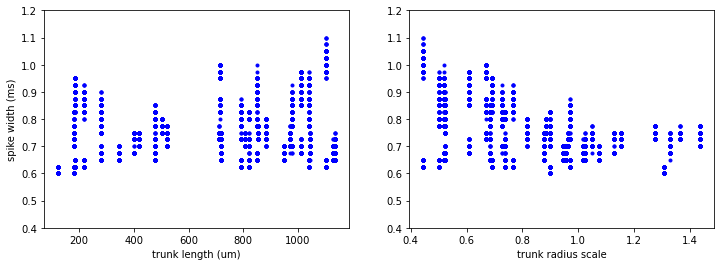

In [26]:
with STATS:
    sim_labels = STATS['y']
print('Simulated data')
plt.figure(figsize=(12, 4))
plt.subplot(121)
sim_spike_width = params.DT * (sim_stats[:, 41] - sim_stats[:, 39])
plt.plot(sim_labels[:, label_list.index('l_t')], sim_spike_width, 'b.')
plt.ylim([0.4, 1.2])
plt.xlabel('trunk length (um)')
plt.ylabel('spike width (ms)')
plt.subplot(122)
plt.plot(sim_labels[:, label_list.index('r_t')], sim_spike_width, 'b.')
plt.ylim([0.4, 1.2])
plt.xlabel('trunk radius scale')
plt.show()

In [27]:
# FIG_PATH = os.path.join(paths.FIGURE_ROOT, 'In_Vivo_Gallery')
# # Find interneurons
# spk_width_cutoff = 0.5
# with open(os.path.join(FIG_PATH, 'Putative_interneurons.txt'), 'w') as f:
#     print('Spike width < %.3g' % spk_width_cutoff, file=f)
#     print(IDs[np.nonzero(spike_width < spk_width_cutoff)[0]], file=f)

### Check LFP

In [28]:
select_ID = 531 #227 531 #78
select_id = np.nonzero(ids==select_ID)[0][0]
select_stats = invivo_stats[good_indices][select_id]

display(df_pred.loc[[select_ID]])

,y,d,theta,l_t,lr_pt,r_t,rr_dt,layer
cell id,,,,,,,,
531,184.58147,109.70609,0.28128,992.5788,-0.058479,1.224168,0.487948,Layer5


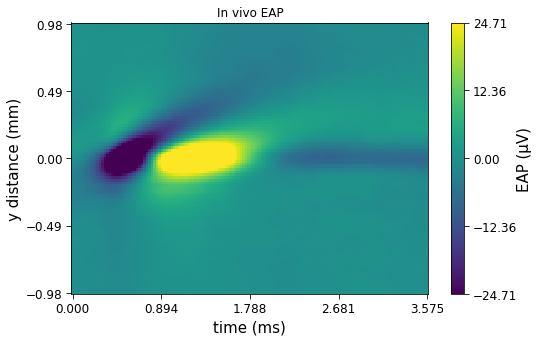

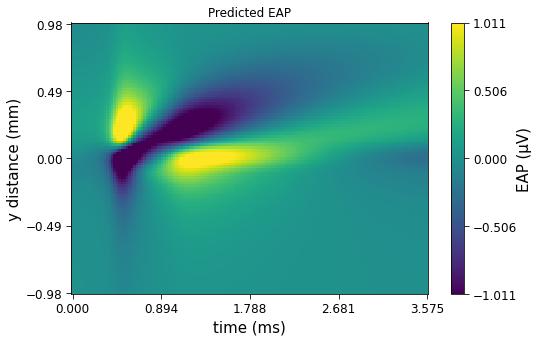

In [29]:
max_mag_idx_x = np.asarray(max_mag_idx) - 2  # max magnitue x idx
ix = int(select_stats[max_mag_idx_x][np.argmax(select_stats[max_mag_idx])])
fontsize = 15
labelpad = 0
ticksize = 12
tick_length = 5
nbins = 5

grid_shape = (ss2.GRID_SHAPE[0], ss2.NY)
elec_d = ss2.REL_IDX * ss2.DY
lfp_invivo = 1000 * invivo_lfp[select_id].reshape((-1,) + grid_shape)[:, ix, :]  # mV -> uV
lfp_pred = 1000 * pred_lfp[select_id].reshape((-1,) + grid_shape)[:, ix, :]

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=lfp_invivo,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('In vivo EAP')
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=lfp_pred,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('Predicted EAP')
plt.show()

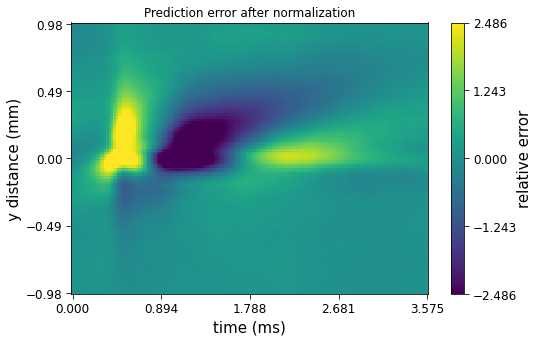

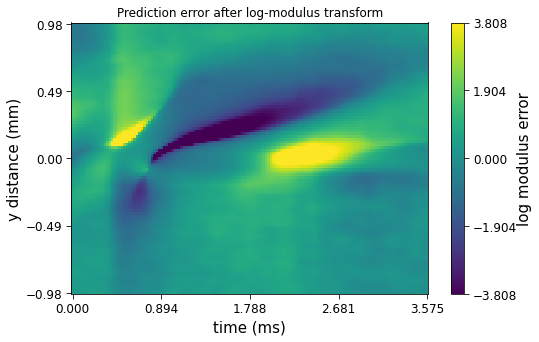

In [30]:
# relative error
rel_err = pred_lfp[select_id] / pred_lfp[select_id].std() - invivo_lfp[select_id] / invivo_lfp[select_id].std()
rel_err = rel_err.reshape((-1,) + grid_shape)[:, ix, :]
# log modulus error
log_err = log_moulus_nfold(pred_lfp[select_id], n_fold) - log_moulus_nfold(invivo_lfp[select_id], n_fold)
log_err = log_err.reshape((-1,) + grid_shape)[:, ix, :]

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=rel_err,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='relative error', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('Prediction error after normalization')
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=log_err,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='log modulus error', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('Prediction error after log-modulus transform')
plt.show()

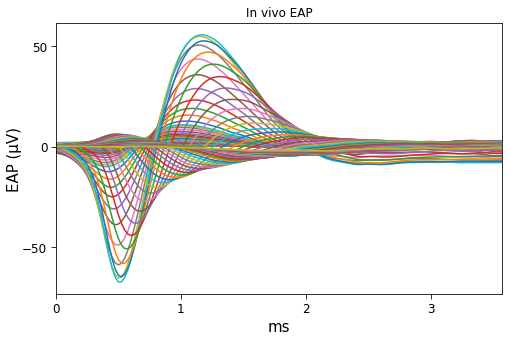

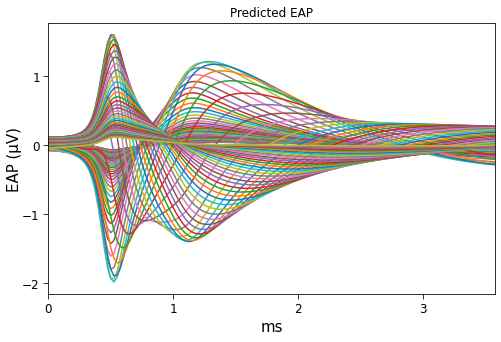

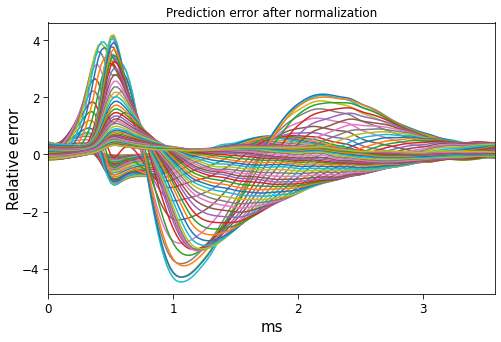

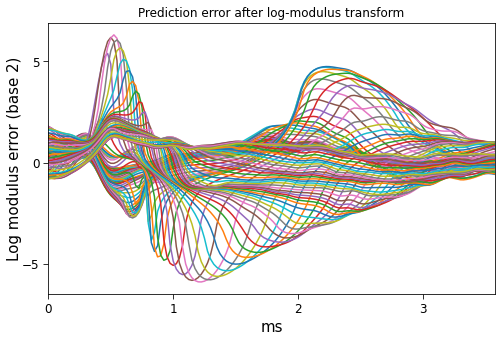

In [31]:
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_invivo, #electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel('EAP (μV)')
plt.title('In vivo EAP')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_pred, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel('EAP (μV)')
plt.title('Predicted EAP')

plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, rel_err, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Prediction error after normalization')
plt.ylabel('Relative error')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, log_err, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Prediction error after log-modulus transform')
plt.ylabel('Log modulus error (base 2)')
plt.show()